# Plotting Camera Derived Snow Depths

**Goal**: Plot all camera location with pit locations. Then plot a timeseries of one camera in the trees and one in the open.

**Approach**:

1. Grab all the Site data for the pits and all the camera locations
2. Plot the pits and sites all together 
3. Grab and Plot the Vegetated and Open Camera sites 


## Process

### Step 1: Grab all the pit and camera locations

In [1]:
from snowexsql.db import get_db
from snowexsql.data import PointData, SiteData
from snowexsql.conversions import query_to_geopandas

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# Connect to the database 
db_name = 'localhost/snowex'
engine, session = get_db(db_name, credentials='./credentials.json')

# Grab all the point data that was that was measured with a camera-trap
qry = session.query(PointData)
qry = qry.filter(PointData.instrument == 'camera-trap')

# Convert it to a geopandas df 
camera_depths = query_to_geopandas(qry, engine)

# Grab all the unique pits geometry objects (locations)
qry = session.query(SiteData.geom).distinct()
pits = query_to_geopandas(qry, engine)

# Print out how many of each that we found
print(f'Found {len(camera_depths["geom"].unique())} camera trap locations')
print(f'Found {len(pits.index)} pit site locations')

# End our database session to avoid hanging transactions
session.close()


Found 28 camera trap locations
Found 155 pit site locations


### Step 2: Plot our camera and Pit locations

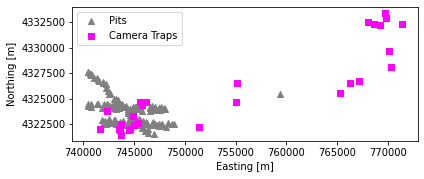

In [2]:
# plot our pits as triangles
ax = pits.plot(marker='^', color='gray', label='Pits')

# Plot our cameras as squares
ax = camera_depths.plot(ax=ax, color='magenta', marker='s', label='Camera Traps')

# Don't use scientific notation on the ticks for utm coords
ax.ticklabel_format(style='plain', useOffset=False)
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
ax.legend()
plt.tight_layout()
plt.show()

### Step 3: Grab/Plot the Vegetated and Open Camera sites 

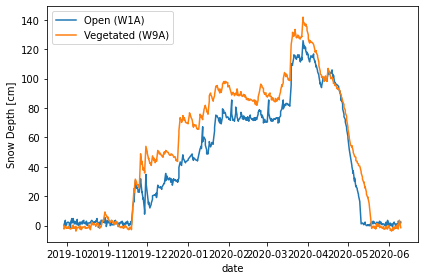

In [3]:
# Grab the open site data from the db
open_site = 'W1A'
veg_site = 'W9A'
qry = session.query(PointData).filter(PointData.equipment.contains(open_site))
df_open = query_to_geopandas(qry,engine)

# Grab the vegetated site from the db 
qry = session.query(PointData).filter(PointData.equipment.contains(veg_site))
df_veg = query_to_geopandas(qry,engine)

# Set the date as the index for easy plotting/reading
df_open = df_open.set_index('date')
df_veg = df_veg.set_index('date')

# Plot the 2 datasets by date!
ax = df_open['value'].plot(label=f'Open ({open_site})')
df_veg['value'].plot(ax=ax, label=f'Vegetated ({veg_site})')

# Mess with some labeling to make it look nice
ax.legend()
ax.set_ylabel('Snow Depth [cm]')
plt.tight_layout()
plt.show()